# Analysing Traffic Jams across causeway

In [1]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(10,8))
plt.imshow(plt.imread('../2018-05-15T10:25:28+08:00.jpg'));plt.show()

<Figure size 1000x800 with 1 Axes>

In [2]:
import matplotlib.pyplot as plt
import cv2
from math import pi
import numpy as np
import pandas as pd
import os
files = sorted(os.listdir('./4713'))

# data systematically sampled using LTA API. Sampled 1500 images over 2018

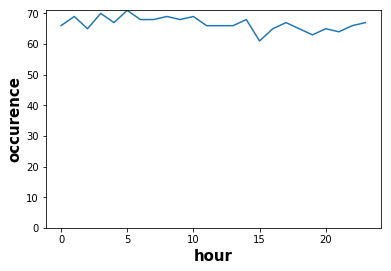

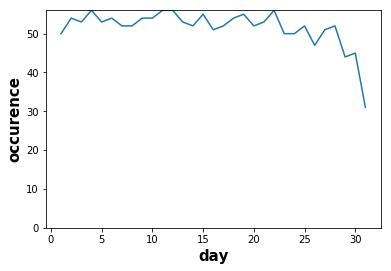

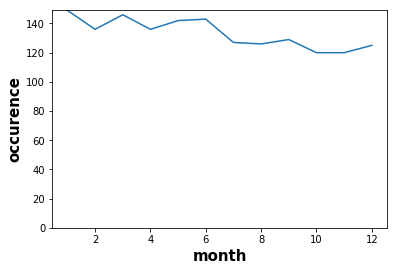

      month  day  hour  min
0         1    1     4   10
200       2   12     0   11
400       3   24    23    7
600       5    8    17   37
800       6   19     4   48
1000      8    5    13   51
1200      9   23    11    3
1400     11   11    10   15


In [3]:
data = pd.DataFrame(files,columns=['filename',])
data['year'] = data['filename'].apply(lambda x : int(x[:4]))
data['month'] = data['filename'].apply(lambda x : int(x.split('-')[1]))
data['day'] = data['filename'].apply(lambda x : int(x.split('-')[2][:2]))
data['hour'] = data['filename'].apply(lambda x : x[11:13]).astype(np.uint32)
data['min'] = data['filename'].apply(lambda x : x[14:16]).astype(np.uint32)
data['sec'] = data['filename'].apply(lambda x : x[17:19]).astype(np.uint32)
data['img'] = data['filename'].apply(lambda x : plt.imread('./4713/'+x).astype(np.float32))
data['img299'] = data['img'].apply(lambda x : cv2.resize(x,(299,299)))
for i in ['hour','day','month']:
    temp = data.groupby(i).apply(len).reset_index(drop=False)
    plt.plot(temp[i],temp[0])
    plt.xlabel(i,fontsize=15,fontweight='bold')
    plt.ylabel('occurence',fontsize=15,fontweight='bold')
    plt.ylim(0,np.max(temp[0]))
    plt.show()
print (data[['month','day','hour','min',]].iloc[::200])

In [4]:
#pretrained models
import tensorflow as tf
# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
#jam classifier model
traffic_jam_classifier =  tf.keras.models.load_model('./keras_model.h5')
# load retinanet model
car_detection_model = models.load_model('./resnet50_csv_03.h5', backbone_name='resnet50')
car_detection_model = models.convert_model(car_detection_model)

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


In [5]:
data['jam'] = traffic_jam_classifier.predict(np.stack(data['img299'].values/255,0),batch_size=8)
import gc
gc.collect()

473

In [32]:
cars

array([[ 46.79623, 182.67278, 136.24783, 246.67021],
       [415.91696, 106.97162, 474.95053, 144.39151]], dtype=float32)

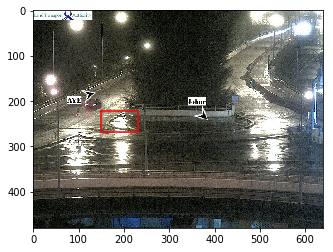

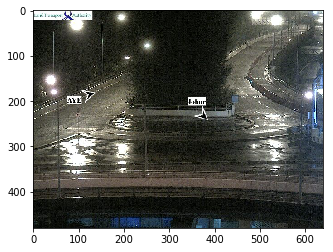

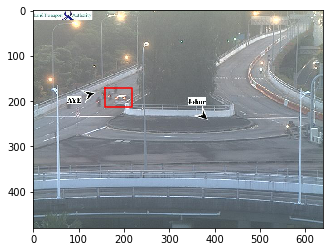

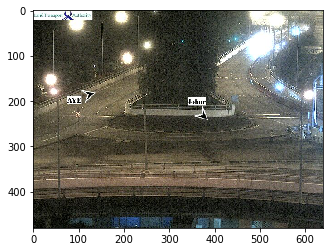

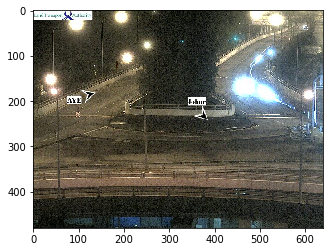

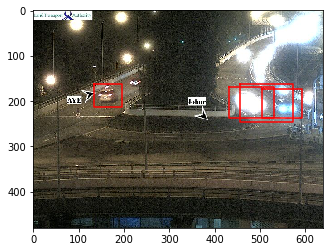

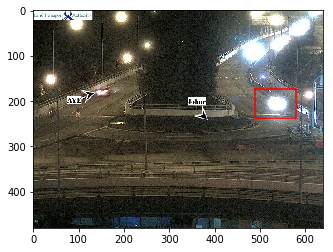

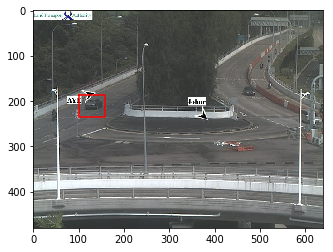

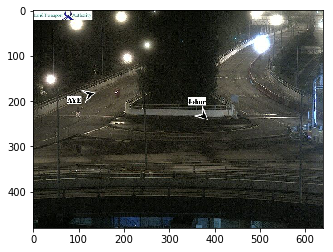

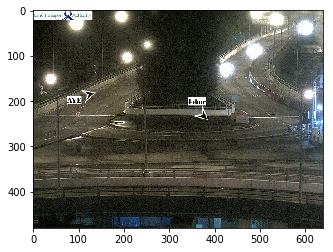

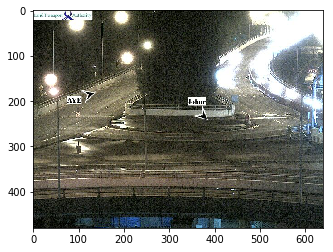

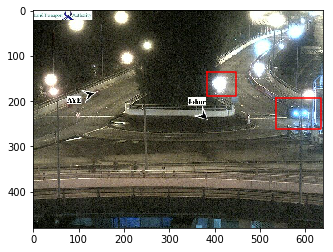

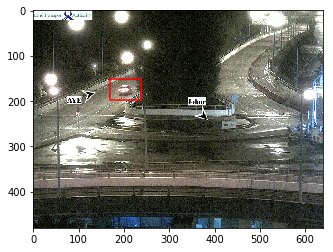

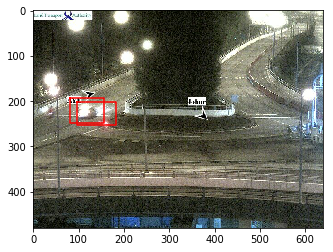

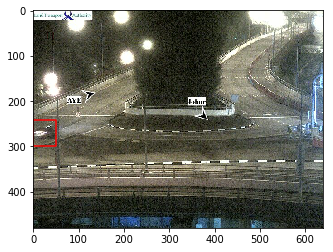

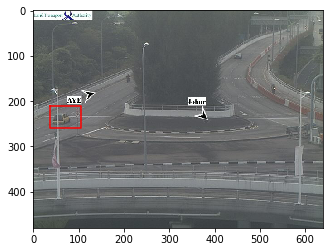

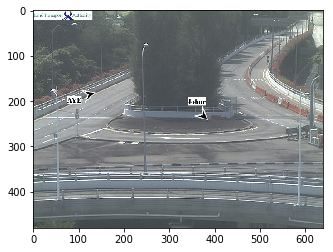

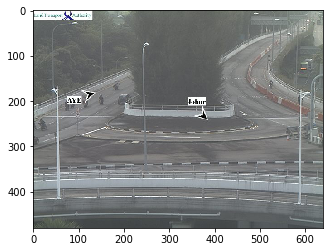

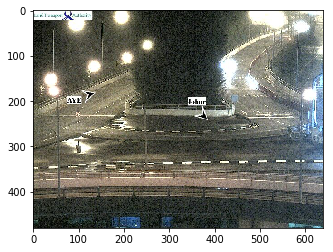

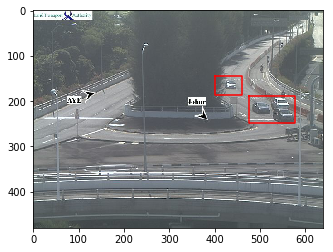

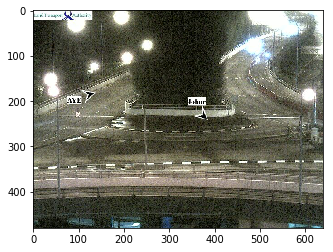

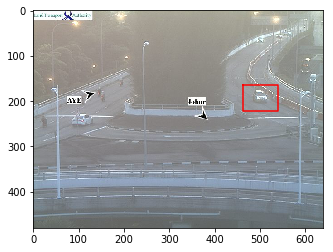

In [39]:
def draw_boxes(img,boxes,scores,labels):
    plt.imshow(img)
    for i1,i2,i3,i4 in boxes[0,scores[0,:]>0.15]:
        plt.plot([i1,i3,i3,i1,i1],[i2,i2,i4,i4,i2],'r');
    plt.show()
temp = []
for i in range(len(data)):
    if data.iloc[i]['jam'] > 0.5:
        temp += [50,]
    else:
        img = data.iloc[i]['img']
        boxes, scores, labels = car_detection_model.predict_on_batch(np.expand_dims(img, axis=0))
        if data.iloc[i]['jam'] < 0.5 and i%50 ==0:
            draw_boxes(img=img.astype(np.uint8),boxes=boxes,scores=scores,labels=labels)
        cars = boxes[0,scores[0,:]>0.15]
        temp += [len(cars[cars[:,0]>400,]),] #get cars in right side, towards tuas
data['num_car'] = temp

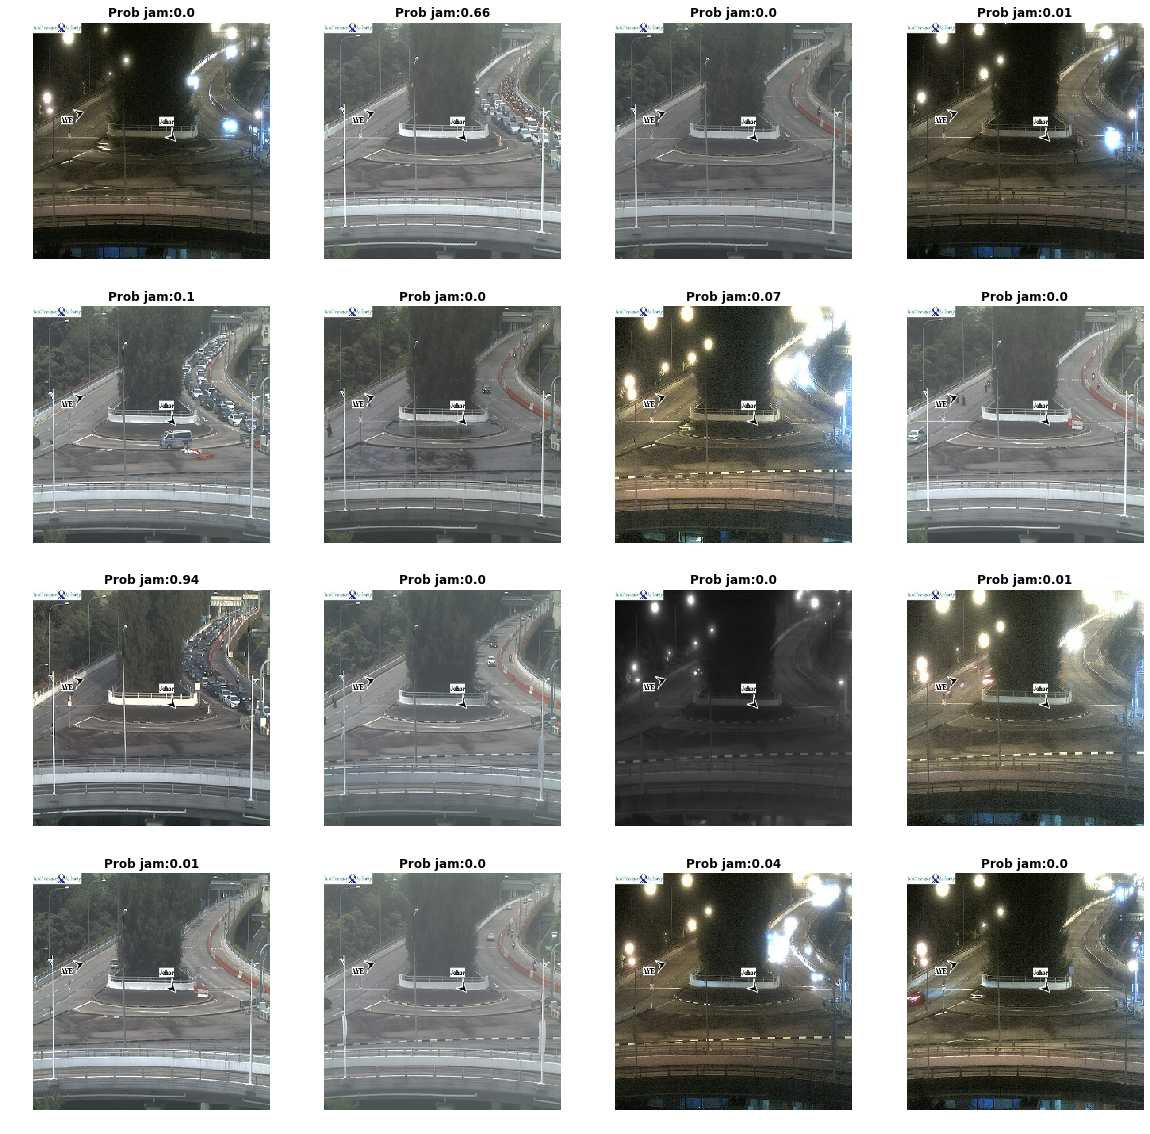

In [7]:
# view predictions if they make sense
fig, ax = plt.subplots(4,4,figsize=(20,20))
temp = data.sample(16).reset_index(drop=True)
counter = 0
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(temp.iloc[counter]['img299'].astype(np.uint8))
        ax[i,j].axis('off')
        ax[i,j].set_title('Prob jam:'+ str(np.round(temp.iloc[counter]['jam'],2)),fontweight='bold')
        counter += 1
plt.show()

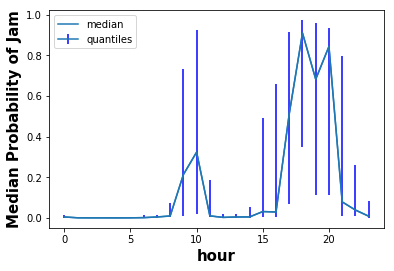

In [62]:
temp = data[['month','day','hour','min','jam']].groupby('hour')['jam'].apply(list).reset_index(drop=False)
temp['median'] = temp['jam'].apply(lambda x : np.median(x))
temp['75'] = temp['jam'].apply(lambda x : np.percentile(x,75)-np.median(x))
temp['25'] = temp['jam'].apply(lambda x : -np.percentile(x,25)+np.median(x))
plt.plot(temp['hour'],temp['median'],label='median')
plt.xlabel('hour',fontsize=15,fontweight='bold')
plt.ylabel('Median Probability of Jam',fontsize=15,fontweight='bold')
#plt.plot(temp2['hour'],list(map(lambda x : np.percentile(x,15),temp2['jam'].values)),'b')
error = temp[['25','75']].values
plt.errorbar(temp['hour'],temp['median'],yerr=error.T,ecolor='b',label='quantiles')
plt.legend()
plt.show()

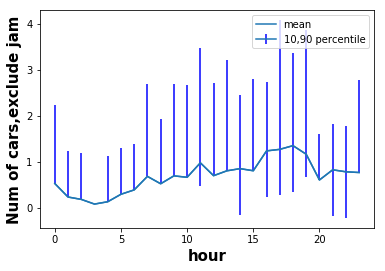

In [63]:
temp = data[data.num_car<50][['month','day','hour','min','num_car']].groupby('hour')['num_car'].apply(list).reset_index(drop=False)
temp['mean'] = temp['num_car'].apply(lambda x : np.mean(x))
temp['75'] = temp['num_car'].apply(lambda x : np.percentile(x,90)-np.median(x))
temp['25'] = temp['num_car'].apply(lambda x : -np.percentile(x,10)+np.median(x))
plt.plot(temp['hour'],temp['mean'],label='mean')
#print (temp)
plt.xlabel('hour',fontsize=15,fontweight='bold')
plt.ylabel('Num of cars,exclude jam',fontsize=15,fontweight='bold')
#plt.plot(temp2['hour'],list(map(lambda x : np.percentile(x,15),temp2['jam'].values)),'b')
error = temp[['25','75']].values
plt.errorbar(temp['hour'],temp['mean'],yerr=error.T,ecolor='b',label='10,90 percentile')
plt.legend()
plt.show()